# Building models

From the previous unit we have already the insight that the features are related to the target in both linear and non-linear ways and also that the interactions between features can lead to changes in the target. Therefore, following this motivation we build linear and non-linear models to predict the one-hour-ahead electric load. 

In this unit we choose simple linear regression and also random forest as the machine learning models, and for each model we decide about the appropriate preprocessing of the features. Furthermore, we choose the mean absolute error as the metrics and the median as the baseline. Here is the outline of the steps we go through in this unit:

- Loading the train/test sets
- Creating a dummy baseline
- Performing the data preprocessing
- Creating the parameter grid and the pipeline
- Creating the cross-validation object: splitting the training set into training and validation sets
- Fitting and prediction
- Post-modeling analysis and improving the baseline

Let's start by loading the necessary libraries and the training and test data that we saved in the previous unit. 

In [1]:
# SKIP

import random
import numpy as np

np.random.seed(0)
random.seed(0)

In [2]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn import set_config

%matplotlib inline

In [3]:
# Load the data
train = pd.read_csv("./data/c4_ts_train.csv", index_col=0, parse_dates=True)
test = pd.read_csv("./data/c4_ts_test.csv", index_col=0, parse_dates=True)

print("Train:", train.shape)
print("Test: ", test.shape)

Train: (8015, 6)
Test:  (744, 6)


In [4]:
# specifying features and the target for train/test sets
X_tr = train.drop(["load"], axis=1)
y_tr = train["load"]
X_te = test.drop(["load"], axis=1)
y_te = test["load"]

X_tr.head()

,month,day,hour,load_lag1,temp_lag1
timestamp,,,,,
2014-01-01 01:00:00,0,2,1,3295.0,-12.592593
2014-01-01 02:00:00,0,2,2,3173.0,-11.851852
2014-01-01 03:00:00,0,2,3,3085.0,-12.777778
2014-01-01 04:00:00,0,2,4,3053.0,-12.777778
2014-01-01 05:00:00,0,2,5,3077.0,-13.333333


Remember that the training set covers the data from January to November whereas the test set contains only the December data.

## Baseline
The idea behind having a baseline is to see if we can rely on the past information as a proxy for what comes in the future without using any machine learning techniques. Here we use the median of the loads in the training set and find it to be 455 Megawatt away from the electric load in the test set which is not bad but still, it is worth seeing if we can get more accurate predictions.

In [5]:
# baseline
baseline = MAE(y_te, np.median(y_tr) * np.ones(len(y_te)))
print("baseline MAE: {:.2f}".format(baseline))

baseline MAE: 455.40


## Linear regression with regularization
Next we develop a ridge regression model which requires one-hot encoding of the categorical features and standardization of the numerical features. We use `OneHotEncoder` to handle the _month, day_ and _hour_ and let the rest i.e. the lags of the load and temperature to be scaled using the `StandardScaler()`. Alternatively, we could define a separate transformer for numerical features and apply it using the `ColumnTransformer` estimator.

In [6]:
# One-hot encoding for categorical columns
cat_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Applying the transformers
preprocessor = ColumnTransformer(
    [("cat", cat_transformer, ["month", "day", "hour"])], remainder=StandardScaler()
)



> Note that an alternative method for encoding cyclical features such as month, day and hour is to use the sine and cosine functions.
   

We are now ready to put the _preprocessor_ of the data in a pipeline along with the ridge regression estimator. We use the `TimeSeriesSplit` from the previous unit to create a cross-validator object. We set the number of splits to be 5 and the validation set to be 1 month i.e. 24 hours multiplied by 30 days.


    
> Unlike the K-Folds cross-validator where we can shuffle the data before splitting them, we do not shuffle the time series data because the samples typically don't satisfy the criteria of independent and identically distributed random samples.
   

We use the pipeline as the estimator, a grid of the hyperparameter $\alpha$, and the cross-validator object to do both grid search and cross-validation using the `GridSearchCV` object.

In [7]:
# Create the pipeline
pipe_ridge = Pipeline([("preprocessor", preprocessor), ("ridge", Ridge())])

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1)  # 1 month validation

# Create grid for alpha
grid = {"ridge__alpha": np.logspace(-4, 4, num=20)}

# Create the grid search object
model_ridge = GridSearchCV(
    pipe_ridge,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

Note that for the scoring function we use `neg_mean_absolute_error` to evaluate the performance of the model. 
`neg_mean_absolute_error` is a scoring function for __regression__ problems and will be maximized for each value of hyperparameter in the grid. Now we have all the objects ready to fit the estimator on the training set and predict on the test set. Let's start training the model.

In [8]:
# Fit on the training set
model_ridge.fit(X_tr, y_tr)

# Evaluate on the test set
y_pred_ridge = model_ridge.predict(X_te)

ridge_mae = MAE(y_te, y_pred_ridge)
print("ridge regression MAE: {:.2f}".format(ridge_mae))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
ridge regression MAE: 52.49


The resulting error is about 9 times smaller than the baseline which is a huge gain. Let's now step back and review what we did during the grid search and cross-validation. We check the following:

- How did the preprocessing go?
- What was the outcome of the grid search?
- What was the outcome of the cross-validation?
- Does the model overfit?


Below we can quickly see the pipeline steps in a diagram.

In [9]:
# SKIP-OUTPUT

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display="diagram")

# Let's visualize the best estimator from grid search.
model_ridge.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day', 'hour'])])),
                ('ridge', Ridge(alpha=1.623776739188721))])

The pipeline steps are carried out as expected. The diagram also shows the optimal value of $\alpha$. We discuss this in more detail soon.

Let's print the results of the grid search and cross-validation. Each row in the following table shows some metrics for one value of $\alpha$ in the grid. 

In [10]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model_ridge.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_ridge__alpha",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_ridge__alpha
10,-56.497648,10.829177,-49.139631,0.995847,1.623777
9,-56.513229,10.872032,-49.142823,0.995649,0.615848
8,-56.521073,10.887943,-49.145516,0.995283,0.233572
7,-56.524325,10.893912,-49.146727,0.995113,0.088587
6,-56.525571,10.896179,-49.147229,0.995025,0.033598


The optimal $\alpha$ appears in the first row because the results are sorted by the validation scores (named `mean_test_score`). 
The optimal $\alpha$ is the one that minimizes the MAE of the validation set. But the reason that there exists such a hyperparameter in the [objective function](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is to control the regularization strength. More precisely, $\alpha$ regulates how much each of the main parameters in the model can contribute to the fit. In general, regularization is needed to ensure that the model can generalize well on the unseen data. Let's see if this is the case here. 

The smallest validation error is 56.49 which is not very far from the training error of 49.13 (15% higher). Ideally, a model should do as well on the validation data as it does on the train data. Here the gap is not too large. But the part that is not desirable is the variation in the validation error (measured by `std_test_score`) which is around 10.82. This is too much compared to that of the training error which is about just 0.99. So, the validation error can oscillate between $56.49-10.82$ and $56.49+10.82$. In sum, the cross-validation showed that the model is not robust when exposed to unseen data.

The following plot also illustrates some of the results we just discussed.

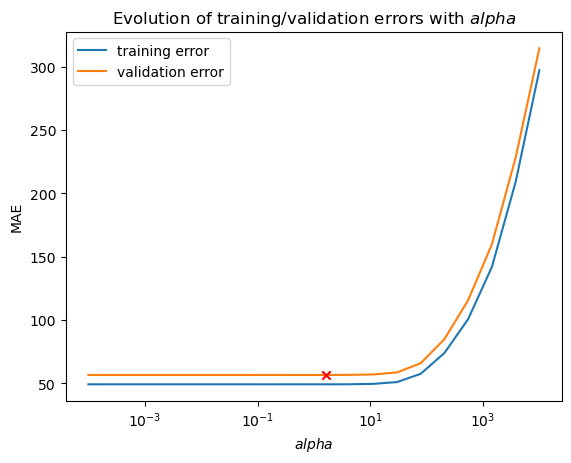

In [11]:
# Plot train and validation curves
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.semilogx(
    cv_results["param_ridge__alpha"],
    -cv_results["mean_test_score"],
    label="validation error",
)

# Add marker for best score
plt.scatter(
    model_ridge.best_params_.values(),
    -1 * model_ridge.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with $alpha$")

plt.legend()
plt.show()

In sum, the model slightly overfits as the validation error is about 10% higher than the training error, and changing $\alpha$ doesn't help address this issue. One possible explanation for this issue is in the structure and size of the data set. More precisely, since the validation set (e.g. July) always comes ahead of the train set (e.g. January to June), the model cannot generalize to the attributes that are specific to July. A solution for this issue is to increase the size of the train set, e.g. training the model on a full year.

Let's move to the second model i.e. the random forest.

In [12]:
# SKIP

import random
import numpy as np

np.random.seed(0)
random.seed(0)

## Random forest
Next we develop a random forest to predict the one-hour-ahead load. We follow the steps as in the case of the linear model but there are two main differences. firstly, we don't need to scale the numerical features and therefore use `remainder="passthrough"` in the `ColumnTransformer`. Secondly, we tune the hyperparameter `n_estimators`.

In [13]:
# Applying the transformers without scaling
preprocessor = ColumnTransformer(
    [("cat", cat_transformer, ["month", "day", "hour"])], remainder="passthrough"
)

# Create pipeline
pipe_rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("rf", RandomForestRegressor(min_samples_split=20)),
    ]
)

# Create cross-validation object
cv = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1)  # 1 month validation

# Create grid for alpha
grid = {"rf__n_estimators": np.arange(1, 131, 10)}

# Create the grid search object
model_rf = GridSearchCV(
    pipe_rf,
    grid,
    cv=cv,
    return_train_score=True,
    scoring="neg_mean_absolute_error",
    verbose=1,
)

In [14]:
# Fit on the training set
model_rf.fit(X_tr, y_tr)

# Evaluate on the test set
y_pred_rf = model_rf.predict(X_te)

rf_mae = MAE(y_te, y_pred_rf)
print("random forest regression MAE: {:.2f}".format(rf_mae))

Fitting 5 folds for each of 13 candidates, totalling 65 fits
random forest regression MAE: 43.26


As expected from the previous unit, the random forest model beats the linear model. It is capturing the non-linearities. But let's check the generalisability and robustness of the model.

In [15]:
# SKIP-OUTPUT

# Lets visualize the best estimator from grid search.
model_rf.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day', 'hour'])])),
                ('rf',
                 RandomForestRegressor(min_samples_split=20, n_estimators=61))])

In [16]:
# Collect results in a DataFrame
cv_results = pd.DataFrame(model_rf.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_rf__n_estimators",
]
cv_results[cols].sort_values("mean_test_score", ascending=False).head(5)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_rf__n_estimators
6,-50.115954,11.213944,-31.640122,0.959644,61
10,-50.558271,11.683962,-31.520713,0.882441,101
5,-50.655302,11.088762,-31.631915,1.030459,51
12,-50.744582,11.116431,-31.475504,0.858030,121
7,-50.799005,11.866583,-31.610086,0.896572,71


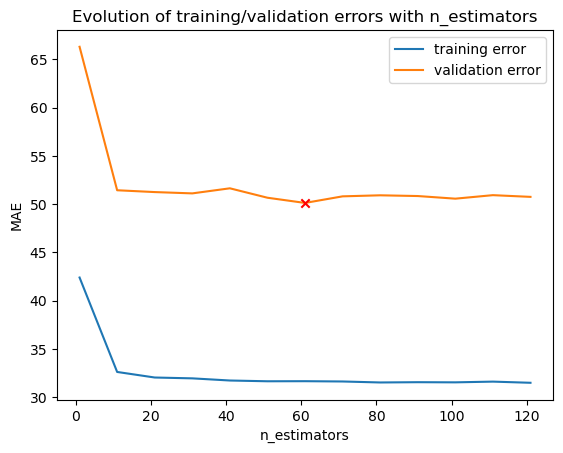

In [17]:
# Plot test curve
plt.plot(
    cv_results["param_rf__n_estimators"],
    -cv_results["mean_train_score"],
    label="training error",
)
plt.plot(
    cv_results["param_rf__n_estimators"],
    -cv_results["mean_test_score"],
    label="validation error",
)

plt.scatter(
    model_rf.best_params_.values(),
    -1 * model_rf.best_score_,
    marker="x",
    c="red",
    zorder=10,
)
plt.xlabel("n_estimators")
plt.ylabel("MAE")
plt.title("Evolution of training/validation errors with n_estimators")
plt.legend()
plt.show()

The performance on the validation set doesn't improve significantly by increasing the number of estimators. The overfitting is evident even stronger compared to the linear model. The validation error is about 60% higher than the training error (50 vs 31), and there is too much uncertainty around the performance of the model on validation data. Tuning other hyperparameters of the model may help but as discussed for the case of the linear model, training the model on a larger train set can mitigate the overfitting. 

## Comparing performances 
The two models show huge reductions in the mean absolute error compared to the baseline when predicting on the test set according to the following bar chart. In the other plot we show the predicted load with the two models along with the observed loads for a single day in the test set. The plot shows that from 1am to around 5am the random forest outperforms the ridge regression, whereas from 6am to around 3pm the ridge regression shows more accurate predictions. Finally, from around 4pm to midnight both models fails to closely predict the one-hour-ahead loads.

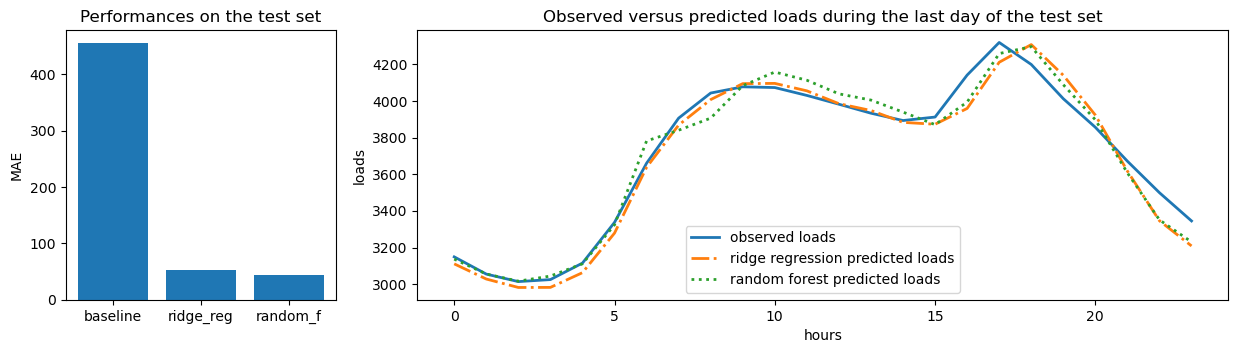

In [18]:
fig, axes = plt.subplots(
    1, 2, figsize=(15, 3.5), gridspec_kw={"wspace": 0.15, "width_ratios": [1, 3]}
)

axes[0].bar(np.arange(3), [baseline, ridge_mae, rf_mae])
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(("baseline", "ridge_reg", "random_f"))
axes[0].set_ylabel("MAE")
axes[0].set_title("Performances on the test set")

axes[1].plot(y_te.values[-1 * 24 :], lw=2, label="observed loads")
axes[1].plot(
    y_pred_ridge[-1 * 24 :], ls="-.", lw=2, label="ridge regression predicted loads"
)
axes[1].plot(y_pred_rf[-1 * 24 :], ls=":", lw=2, label="random forest predicted loads")

axes[1].set_title("Observed versus predicted loads during the last day of the test set")
axes[1].set_xlabel("hours")
axes[1].set_ylabel("loads")
axes[1].legend()

plt.show()



> As you could guess from the previous unit the feature `load_lag1` plays the main role in predicting the target.
This is a common property of some time series data and is called __autoregression__ meaning that the target variable depends linearly on its own previous values (remember the 0.95 auto-correlation from the previous unit).
In time series analysis, a model where the target `load` depends on `load_lag1` and random noise is called an autoregressive order one or briefly AR(1).


Note that you can even consider the load from the previous hour as a prediction for the current load without any modeling. In other words, the lagged loads `load_lag1` can act as a (smart) baseline before building any model. Below, you can see how the performance of such baseline can be compared with the other baseline and models.

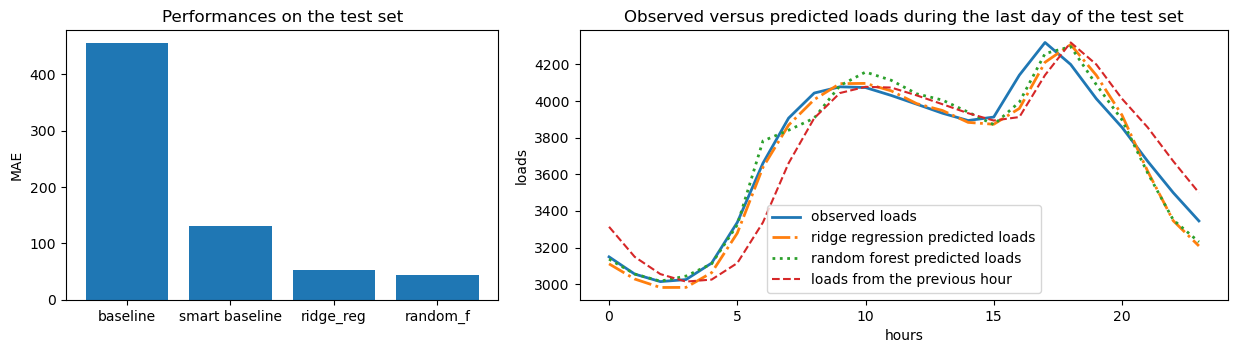

In [19]:
# SKIP-INPUT
baseline2_mae = MAE(y_te, X_te["load_lag1"])
# print("smart baseline MAE: {:.2f}".format(baseline2_mae))

fig, axes = plt.subplots(
    1, 2, figsize=(15, 3.5), gridspec_kw={"wspace": 0.15, "width_ratios": [2, 3]}
)

axes[0].bar(np.arange(4), [baseline, baseline2_mae, ridge_mae, rf_mae])
axes[0].set_xticks(np.arange(4))
axes[0].set_xticklabels(("baseline", "smart baseline", "ridge_reg", "random_f"))
axes[0].set_ylabel("MAE")
axes[0].set_title("Performances on the test set")

axes[1].plot(y_te.values[-1 * 24 :], lw=2, label="observed loads")
axes[1].plot(
    y_pred_ridge[-1 * 24 :], ls="-.", lw=2, label="ridge regression predicted loads"
)
axes[1].plot(y_pred_rf[-1 * 24 :], ls=":", lw=2, label="random forest predicted loads")
axes[1].plot(
    X_te["load_lag1"].values[-1 * 24 :],
    ls="--",
    lw=1.5,
    label="loads from the previous hour",
)

axes[1].set_title("Observed versus predicted loads during the last day of the test set")
axes[1].set_xlabel("hours")
axes[1].set_ylabel("loads")
axes[1].legend()

plt.show()

The plots show that the two models don't remarkably outperform the smart baseline as they did to the first baseline. This is a common situation for time series data with high auto-correlation which may put machine learning models in time series analysis in difficult position to be justified and deployed. In particular, in time series data without seasonalities it may be very difficult to beat the smart baseline.

Note that our objective was to build models that can predict the electric loads one hour ahead. But you can change this prediction horizon to be more than only one hour. Deciding about the prediction horizon depends on the domain, the problem that is intended to be solved, and the policy implication of the machine learning project. For instance, in macroeconomics it is desirable for policymakers to have an idea about the dynamics of the economy several years in advance. However, for a trader in the financial markets predicting the dynamics of an index even a few seconds in advance is valuable.

## Summary
Here is a quick summary of what we did in this unit:

- We framed a regression problem and used the ridge regression and the random forest regressor to address it.
- We showed different preprocessing steps for each model in the pipeline.
- We showed how to perform cross-validation for time series data.
- We trained the data on the training sets, tuned the hyperparameters on the validated sets and predicted on the test set.